In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from textblob import TextBlob


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
bnb_data = pd.read_csv('../data/processed/sf_airbnb_listings_cleaned.csv')

In [3]:
bnb_data.dtypes

Unnamed: 0                     int64
Unnamed: 0.1                   int64
summary                       object
space                         object
description                   object
house_rules                   object
host_listings_count            int64
host_total_listings_count      int64
neighborhood                  object
zipcode                       object
latitude                     float64
longitude                    float64
is_location_exact             object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
amenities                     object
price                          int64
minimum_nights                 int64
maximum_nights                 int64
availability_30                int64
availability_60                int64
availability_90                int64
availability_365               int64
number_of_reviews              int64
r

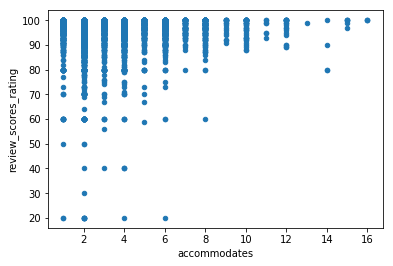

In [4]:
bnb_data.plot.scatter(x='accommodates', y='review_scores_rating')

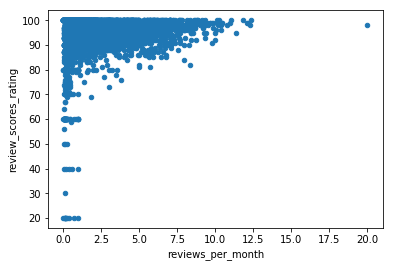

In [5]:
bnb_data.plot.scatter(x='reviews_per_month', y='review_scores_rating')

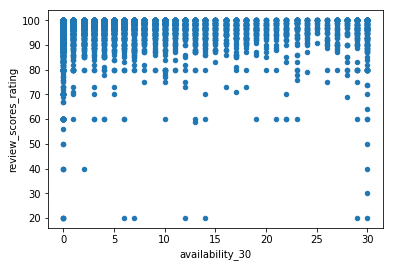

In [6]:
bnb_data.plot.scatter(x='availability_30', y='review_scores_rating')

We collect two metrics with text data -- sentiment and length

In [7]:
text_cols = ['house_rules', 'summary', 'space', 'description']

for col in text_cols:
    bnb_data[col] = bnb_data[col].fillna('')

def text_len(row):
    total = 0
    for col in text_cols:
        total += len(row[col])
    return total

def analyze_tone(row):
    total = 0
    for col in text_cols:
        if row[col]:
            blob = TextBlob(row[col])
            total += blob.sentiment.polarity
        
    return total

bnb_data['sentiment'] = bnb_data.apply(
    lambda r: analyze_tone(r),
    axis=1
)

bnb_data['text_len'] = bnb_data.apply(
    lambda r: text_len(r),
    axis=1
)

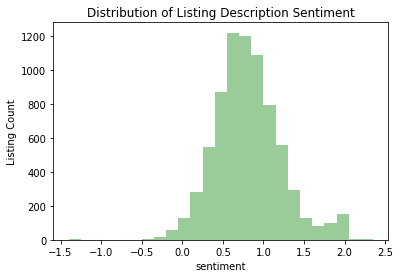

In [8]:
plot = sns.distplot(bnb_data['sentiment'], bins=25, color='g', kde=False).set_title('Distribution of Listing Description Sentiment')

plt.ylabel('Listing Count')

fig = plot.get_figure()
fig.savefig('sentiment_dist.png', dpi=300, transparent=False, format="png")

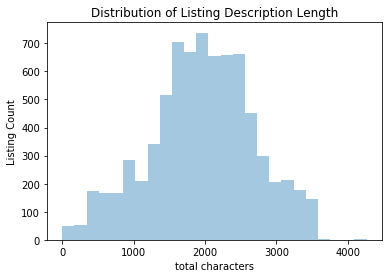

In [9]:
plot = sns.distplot(bnb_data['text_len'], bins=25, kde=False, axlabel='total characters').set_title('Distribution of Listing Description Length')

plt.ylabel('Listing Count')

fig = plot.get_figure()
fig.savefig('length_dist.png', dpi=300, transparent=False, format="png")

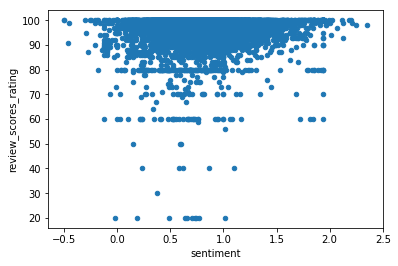

In [10]:
bnb_data.plot.scatter(x='sentiment', y='review_scores_rating')

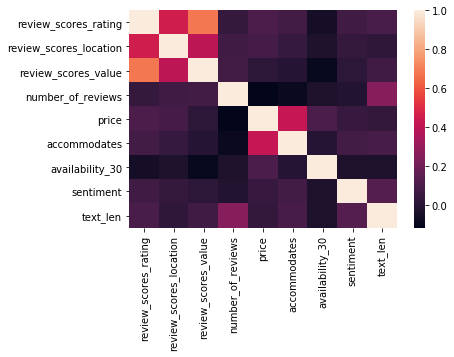

In [11]:
mat = bnb_data[['review_scores_rating', 'review_scores_location', 'review_scores_value', 'number_of_reviews', 'price', 'accommodates', 'availability_30',  'sentiment', 'text_len']].corr()
sns.heatmap(mat)


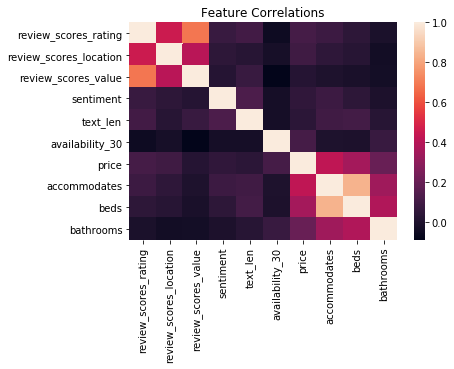

In [12]:
mat = bnb_data[['review_scores_rating', 'review_scores_location', 'review_scores_value', 'sentiment', 'text_len', 'availability_30', 'price', 'accommodates', 'beds', 'bathrooms']].corr()
plot = sns.heatmap(mat).set_title('Feature Correlations')

fig = plot.get_figure()
fig.savefig('heat_matrix.png', dpi=300, transparent=False, format="png", bbox_inches='tight')

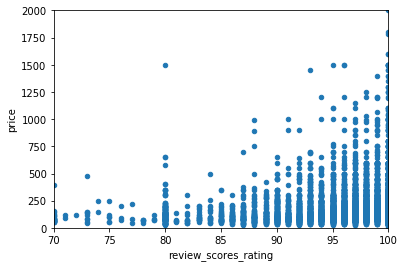

In [13]:
bnb_data.plot.scatter(x='review_scores_rating', y='price', xlim=(70, 100), ylim=(0, 2000))

bnb_data.plot.scatter(x='sentiment', y='price', s=1, xlim=(-0.5, 2), ylim=(0, 2000))

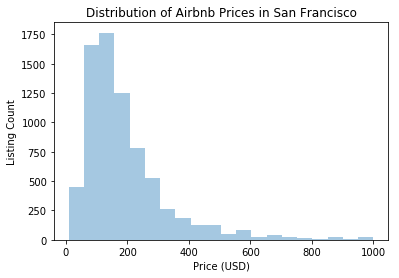

In [14]:
plot = sns.distplot(bnb_data.query('price < 1000')['price'], bins=20, axlabel='Price (USD)', kde=False).set_title('Distribution of Airbnb Prices in San Francisco')

plt.ylabel('Listing Count')

fig = plot.get_figure()
fig.savefig('price_dist.png', dpi=300, transparent=False, format="png")

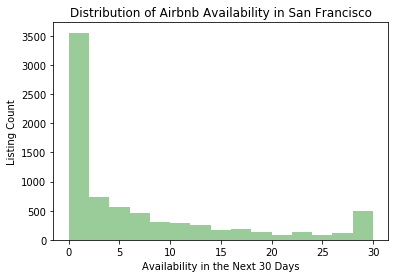

In [15]:
plot = sns.distplot(bnb_data['availability_30'], bins=15, axlabel='Availability in the Next 30 Days', kde=False, color='g').set_title('Distribution of Airbnb Availability in San Francisco')

plt.ylabel('Listing Count')

fig = plot.get_figure()
fig.savefig('availability_dist.png', dpi=300, transparent=False, format="png")

In [16]:
anom = IsolationForest()
anomaly = anom.fit_predict(bnb_data[['price', 'accommodates', 'beds', 'bathrooms', 'bedrooms']])

/home/justin/.local/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/justin/.local/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/justin/.local/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


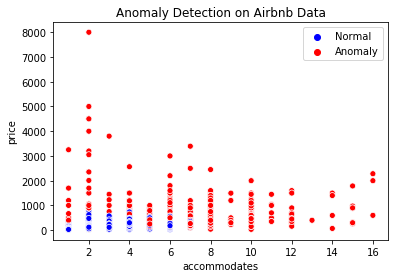

In [22]:
def convert(x):
    if x == 1:
        return "Normal"
    else:
        return "Anomaly"
anomaly_labels = list(map(convert, anomaly))

colors = {"Normal": "#0000ff", "Anomaly": "#ff0000"}
plot = sns.scatterplot(bnb_data['accommodates'], bnb_data['price'], anomaly_labels, palette=colors)
plt.title("Anomaly Detection on Airbnb Data")
fig = plot.get_figure()
fig.savefig('anomaly_detection.png', dpi=300, transparent=False, format="png")

In [26]:
pd.Series(anomaly).value_counts()

 1    6793
-1     755
dtype: int64

In [22]:
bnb_data = pd.concat([bnb_data, pd.DataFrame(data=anomaly, columns=['anomaly'])], axis=1)
bnb_data = bnb_data.query('anomaly == 1')

In [23]:
def run_model(model_name, model_factory, data, x_cols):
    X_train, X_test, y_train, y_test = train_test_split(data[x_cols], data['price'], test_size=.2, random_state=0)
    
    m = model_factory()
    m.fit(X_train, y_train)
    
    train_accuracy = m.score(X_train, y_train)
    test_accuracy = m.score(X_test, y_test)
    
    preds = m.predict(X_test)
    
    avg_deviation = sum([abs(pred-price)/price for (pred, price) in zip(preds, data['price'])])/len(preds)
    
#     print(model_name)
#     print(f'Accuracy on training data: {train_accuracy}')
#     print(f'Accuracy on test data: {test_accuracy}')
#     print(f'Average deviation: {avg_deviation}')
    sns.scatterplot(x=y_test, y=preds)
    
    return m


Ok results without any big feature engineering.  Text features are not good predictors of price

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

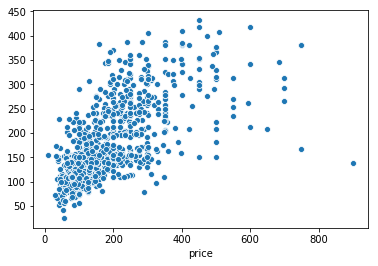

In [24]:
train_data = bnb_data.query('not review_scores_rating.isnull() and not review_scores_location.isnull()')

reg_cols = ['review_scores_rating', 'review_scores_location', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30']

run_model('Gradient Boost', GradientBoostingRegressor, train_data, reg_cols)

In [25]:
bnb_data['supervisor_district'].unique()

array([ 8.,  9.,  5.,  2., 10.,  3.,  6.,  1.,  7.,  4., 11., nan])

In [26]:
def do_onehots(data, cols):
    for col in cols:
        data[col] = data[col].fillna('')
    
    encodings = []
    onehot_cols = []
    for col in cols:
        encodings.append( pd.get_dummies(data[col], prefix=col) )
        onehot_cols += [col + '_' + x for x in data[col].unique()]
    
    return pd.concat([data] + encodings, axis=1), onehot_cols

bnb_data[['supervisor_district']] = bnb_data[['supervisor_district']].astype(str)
bnb_data_onehot, onehot_cols = do_onehots(bnb_data, ['room_type', 'neighborhood', 'zipcode', 'supervisor_district'])

                     feature    importance
4                   bedrooms  4.581557e+01
3                  bathrooms  2.141622e+01
2               accommodates  1.732008e+01
0       review_scores_rating  1.852485e+00
6            availability_30  1.840210e+00
5                       beds -2.079220e-01
1     review_scores_location -1.647701e+00
7  room_type_Entire home/apt -6.728947e+11
8     room_type_Private room -6.728947e+11
9      room_type_Shared room -6.728947e+11

          feature    importance
75  zipcode_94015 -1.779206e+11
62  zipcode_94123 -1.779206e+11
74  zipcode_94080 -1.779206e+11
52  zipcode_94105 -1.779206e+11
49  zipcode_94107 -1.779206e+11
60  zipcode_94104 -1.779206e+11
72  zipcode_94158 -1.779206e+11
55  zipcode_94121 -1.779206e+11
59  zipcode_94103 -1.779206e+11
46  zipcode_94117 -1.779206e+11
48  zipcode_94115 -1.779206e+11
51  zipcode_94114 -1.779206e+11
64  zipcode_94108 -1.779206e+11
66  zipcode_94111 -1.779206e+11
68  zipcode_94129 -1.779206e+11
56  zipcode_94

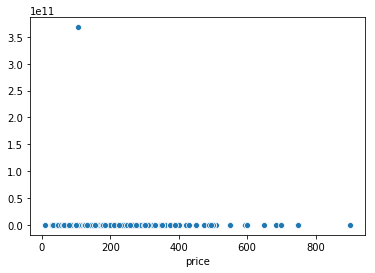

In [27]:
train_data = bnb_data_onehot.query('not review_scores_rating.isnull() and not review_scores_location.isnull()')

reg_cols = ['review_scores_rating', 'review_scores_location', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30'] + onehot_cols

reg_model = run_model('Linear Regression', LinearRegression, train_data, reg_cols)

coefficients = pd.concat([pd.DataFrame(data=reg_cols, columns=['feature']),pd.DataFrame(data=reg_model.coef_, columns=['importance'])], axis = 1)
coefficients = coefficients.sort_values('importance', ascending=False)

print(
    coefficients[coefficients['feature'].str.contains('zipcode_|supervisor_district_|neighborhood_') == False]#, 'supervisor_district_', 'neighborhood_')]
)
print('')

print(
    coefficients[coefficients['feature'].str.contains('zipcode_')]
)
print('')

print(
    coefficients[coefficients['feature'].str.contains('supervisor_district_')]
)
print('')

print(
    coefficients[coefficients['feature'].str.contains('neighborhood_')]
)
print('')

coefficients[coefficients['feature'].str.contains('supervisor_district_')].to_csv('airbnb_district_coef.csv')

/home/justin/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

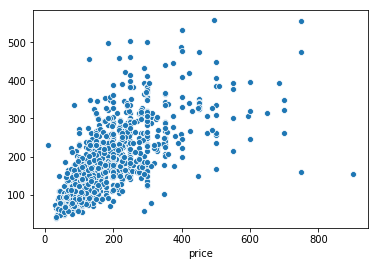

In [28]:
run_model('Random Forest', RandomForestRegressor, train_data, reg_cols)

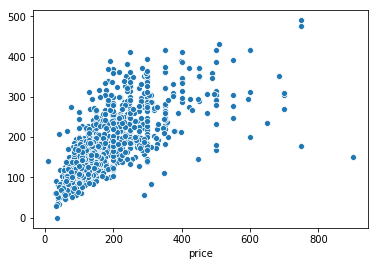

In [29]:
reg_model = run_model('Gradient Boost', lambda: GradientBoostingRegressor(loss='ls'), train_data, reg_cols)

In [30]:
km_data = train_data[['sentiment', 'review_scores_location', 'accommodates', 'price']]
norm_data = (km_data-km_data.min())/(km_data.max()-km_data.min())

km = KMeans(5)
labels = km.fit_predict(norm_data)

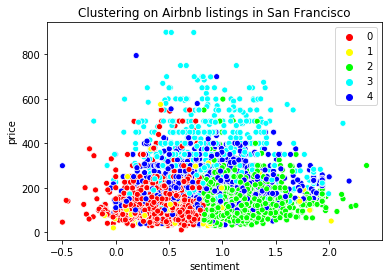

In [31]:
colors = {0: "#ff0000", 1: "#ffff00", 2: "#00ff00", 3: "#00ffff", 4: "#0000ff"}
plot = sns.scatterplot(train_data['sentiment'], train_data['price'], labels, palette=colors, legend="full").set_title('Clustering on Airbnb listings in San Francisco')
fig = plot.get_figure()
fig.savefig( 'airbnb_cluster_1.png', dpi=300, transparent=False, format="png")

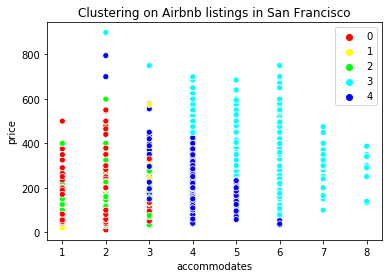

In [35]:
plot = sns.scatterplot(train_data['accommodates'], train_data['price'], labels, palette=colors, legend="full").set_title('Clustering on Airbnb listings in San Francisco')

fig = plot.get_figure()
fig.savefig( 'airbnb_cluster_2.png', dpi=300, transparent=False, format="png")

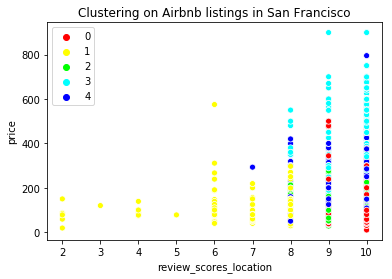

In [34]:
plot = sns.scatterplot(train_data['review_scores_location'], train_data['price'], labels, palette=colors, legend="full").set_title('Clustering on Airbnb listings in San Francisco')

fig = plot.get_figure()
fig.savefig( 'airbnb_cluster_3.png', dpi=300, transparent=False, format="png")